In [ ]:
import datetime
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os

from tensorflow.keras import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout


In [ ]:
import cv2
import urllib
import requests
import PIL.Image
import numpy as np
from bs4 import BeautifulSoup

#ship synset
page = requests.get("http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n04194289")
soup = BeautifulSoup(page.content, 'html.parser')
#bicycle synset
bikes_page = requests.get("http://www.image-net.org/api/text/imagenet.synset.geturls?wnid=n02834778")
bikes_soup = BeautifulSoup(bikes_page.content, 'html.parser')

str_soup=str(soup)
split_urls=str_soup.split('\r\n')

bikes_str_soup=str(bikes_soup)
bikes_split_urls=bikes_str_soup.split('\r\n')

!mkdir /content/train
!mkdir /content/train/ships
!mkdir /content/train/bikes
!mkdir /content/validation
!mkdir /content/validation/ships
!mkdir /content/validation/bikes

img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)

def url_to_image(url):
	resp = urllib.request.urlopen(url)
	image = np.asarray(bytearray(resp.read()), dtype="uint8")
	image = cv2.imdecode(image, cv2.IMREAD_COLOR)

	return image

n_of_training_images=100
for progress in range(n_of_training_images):
    if not split_urls[progress] == None:
      try:
        I = url_to_image(split_urls[progress])
        if (len(I.shape))==3:
          save_path = '/content/train/ships/img'+str(progress)+'.jpg'
          cv2.imwrite(save_path,I)

      except:
        None

for progress in range(n_of_training_images):
    if not bikes_split_urls[progress] == None:
      try:
        I = url_to_image(bikes_split_urls[progress])
        if (len(I.shape))==3:
          save_path = '/content/train/bikes/img'+str(progress)+'.jpg'
          cv2.imwrite(save_path,I)

      except:
        None


for progress in range(50):
    if not split_urls[progress] == None:
      try:
        I = url_to_image(split_urls[n_of_training_images+progress])
        if (len(I.shape))==3:
          save_path = '/content/validation/ships/img'+str(progress)+'.jpg'
          cv2.imwrite(save_path,I)

      except:
        None


for progress in range(50):
    if not bikes_split_urls[progress] == None:
      try:
        I = url_to_image(bikes_split_urls[n_of_training_images+progress])
        if (len(I.shape))==3:
          save_path = '/content/validation/bikes/img'+str(progress)+'.jpg'
          cv2.imwrite(save_path,I)

      except:
        None
          
!ls /content/train/ships
!ls /content/train/bikes       
!ls /content/validation/ships 
!ls /content/validation/bikes

img0.jpg   img24.jpg  img35.jpg  img4.jpg   img62.jpg  img74.jpg  img93.jpg
img11.jpg  img25.jpg  img39.jpg  img51.jpg  img63.jpg  img76.jpg  img94.jpg
img12.jpg  img26.jpg  img3.jpg	 img52.jpg  img64.jpg  img77.jpg  img95.jpg
img14.jpg  img28.jpg  img40.jpg  img54.jpg  img66.jpg  img78.jpg  img96.jpg
img15.jpg  img29.jpg  img43.jpg  img55.jpg  img67.jpg  img83.jpg  img97.jpg
img16.jpg  img31.jpg  img46.jpg  img56.jpg  img69.jpg  img86.jpg  img99.jpg
img17.jpg  img32.jpg  img47.jpg  img59.jpg  img6.jpg   img8.jpg
img18.jpg  img33.jpg  img48.jpg  img5.jpg   img72.jpg  img91.jpg
img23.jpg  img34.jpg  img49.jpg  img60.jpg  img73.jpg  img92.jpg
img10.jpg  img31.jpg  img47.jpg  img5.jpg   img71.jpg  img83.jpg  img98.jpg
img13.jpg  img33.jpg  img48.jpg  img60.jpg  img72.jpg  img84.jpg  img99.jpg
img14.jpg  img35.jpg  img4.jpg	 img63.jpg  img73.jpg  img85.jpg  img9.jpg
img15.jpg  img36.jpg  img51.jpg  img64.jpg  img74.jpg  img86.jpg
img17.jpg  img37.jpg  img53.jpg  img65.jpg  img75.jpg  img87

In [ ]:
num_classes = 2

# some training parameters
EPOCHS = 100
BATCH_SIZE = 32
image_height = 227
image_width = 227
train_dir = "train"
valid_dir = "validation"
model_dir = "my_model.h5"

In [ ]:
train_datagen = ImageDataGenerator(
                  rescale=1./255,
                  rotation_range=10,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  shear_range=0.1,
                  zoom_range=0.1)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(image_height, image_width),
                                                    color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                    seed=1,
                                                    shuffle=True,
                                                    class_mode="categorical")

valid_datagen = ImageDataGenerator(rescale=1.0/255.0)
valid_generator = valid_datagen.flow_from_directory(valid_dir,
                                                    target_size=(image_height, image_width),
                                                    color_mode="rgb",
                                                    batch_size=BATCH_SIZE,
                                                    seed=7,
                                                    shuffle=True,
                                                    class_mode="categorical"
                                                    )
train_num = train_generator.samples
valid_num = valid_generator.samples

Found 117 images belonging to 2 classes.
Found 69 images belonging to 2 classes.


In [ ]:
sample_training_images, _ = next(train_generator)

In [ ]:

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [ ]:
# AlexNet model
class AlexNet(Sequential):
  def __init__(self, input_shape, num_classes):
    super().__init__()

    self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                    padding= 'valid', activation= 'relu',
                    input_shape= input_shape, kernel_initializer= 'he_normal'))
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))
    
    self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None)) 

    self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    
    self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    
    self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                    padding= 'same', activation= 'relu',
                    kernel_initializer= 'he_normal'))
    
    self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                          padding= 'valid', data_format= None))

    self.add(Flatten())
    self.add(Dense(4096, activation= 'relu'))
    self.add(Dense(4096, activation= 'relu'))
    self.add(Dense(1000, activation= 'relu'))
    self.add(Dense(num_classes, activation= 'softmax'))

    self.compile(optimizer= tf.keras.optimizers.Adam(0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [ ]:
num_classes = 2
model = AlexNet((227, 227, 3), num_classes)

In [ ]:
model.summary()

Model: "alex_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 13, 13, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 256)       884

In [ ]:
# some training parameters
model_dir = "alexnet_model.h5"

In [ ]:

log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
callback_list = [tensorboard_callback]
EPOCHS = 100
# start training
history=model.fit(train_generator,
                    epochs=EPOCHS,
                    steps_per_epoch=train_num // BATCH_SIZE,
                    validation_data=valid_generator,
                    validation_steps=valid_num // BATCH_SIZE,
                    callbacks=callback_list,
                    verbose=1)

# save the whole model
model.save(model_dir)

Epoch 1/100
3/3 [==============================] - 9s 922ms/step - loss: 65.0922 - accuracy: 0.5727 - val_loss: 0.6973 - val_accuracy: 0.4531
Epoch 2/100
3/3 [==============================] - 2s 638ms/step - loss: 0.7995 - accuracy: 0.4841 - val_loss: 0.7072 - val_accuracy: 0.4844
Epoch 3/100
3/3 [==============================] - 2s 635ms/step - loss: 0.7119 - accuracy: 0.4696 - val_loss: 0.6919 - val_accuracy: 0.6094
Epoch 4/100
3/3 [==============================] - 2s 655ms/step - loss: 0.6936 - accuracy: 0.4841 - val_loss: 0.7005 - val_accuracy: 0.4531
Epoch 5/100
3/3 [==============================] - 2s 642ms/step - loss: 0.6988 - accuracy: 0.4445 - val_loss: 0.7073 - val_accuracy: 0.4531
Epoch 6/100
3/3 [==============================] - 2s 647ms/step - loss: 0.6997 - accuracy: 0.4677 - val_loss: 0.6801 - val_accuracy: 0.5469
Epoch 7/100
3/3 [==============================] - 2s 688ms/step - loss: 0.6863 - accuracy: 0.4909 - val_loss: 0.6669 - val_accuracy: 0.5156
Epoch 8/100


In [ ]:
%tensorboard --logdir logs/fit

UsageError: Line magic function `%tensorboard` not found.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


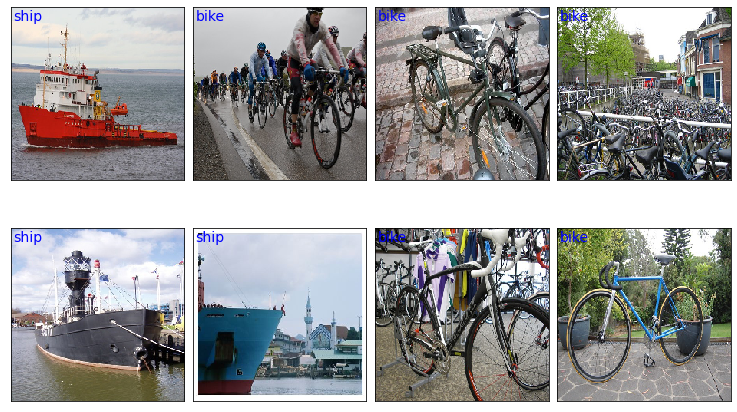

In [ ]:

class_names = ['bike', 'ship']

x_valid, label_batch  = next(iter(valid_generator))

prediction_values = model.predict_classes(x_valid)

# set up the figure
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the images: each image is 227x227 pixels
for i in range(8):
  ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
  ax.imshow(x_valid[i,:],cmap=plt.cm.gray_r, interpolation='nearest')
  
  if prediction_values[i] == np.argmax(label_batch[i]):
    # label the image with the blue text
    ax.text(3, 17, class_names[prediction_values[i]], color='blue', fontsize=14)
  else:
    # label the image with the red text
    ax.text(3, 17, class_names[prediction_values[i]], color='red', fontsize=14)

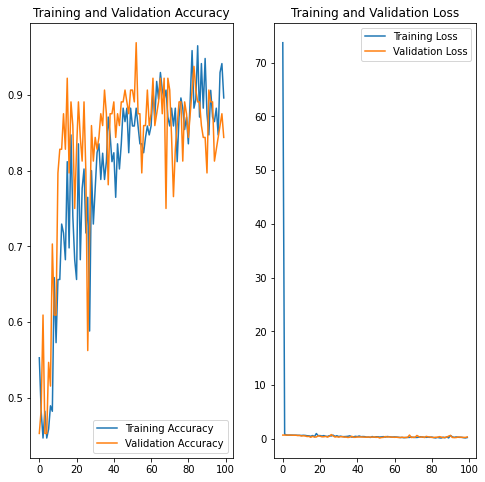

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()